In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.optimize import newton

%config InlineBackend.figure_formats = ['svg']


# Rate Periodicity Conversion
def equivRate(rate, from_freq=1, to_freq=1):
    return to_freq * ((1 + rate / from_freq) ** (from_freq / to_freq) - 1)


# Present Value Function
def pv(r, n, pmt, fv=0, beg=False):
    c = np.full(n, pmt)
    t = np.arange(1, n + 1)
    d = 1.0 / np.power((1 + r), t)
    B = np.sum(d * c)
    tv = fv / (1 + r) ** n

    return np.where(beg, (B + tv) * (1 + r), B + tv)


# Amortizing Loan Principal Outstanding Balance
def principal_out(P, r, N, n):
    d1 = (1 + r) ** N - (1 + r) ** (n - 1)
    d2 = (1 + r) ** N - 1
    return P * d1 / d2


fx_rate = 1 / 3.67
currency = "AED"

In [2]:
start_date = pd.to_datetime("2020-01-01")
end_date = pd.DateOffset(months=12 * 12) + start_date
eval_end_date = pd.to_datetime("2025-07-01")

# Real Estate Investment
property_val = 510_000
down_payment = property_val * 0.2
loan_amount = property_val - down_payment

emi = 3_500
n_period = 12 * 12

interest_rate = newton(
    lambda r: pv(r=r, n=n_period, pmt=emi, beg=False) - loan_amount, x0=0
)

annual_rent = 36_000
annual_rent_gwth = 0.05
annual_appreciation = 0.05
monthly_appreciation = equivRate(annual_appreciation, 1, 12) / 12

# Closing Costs Operating Costs
service_fee = 15 * 484
closing_costs = 28_000  # closing costs = DLD fees + mortgage fees + commissions

# Equity Market Investment
snp500 = yf.Ticker("VOO")  # Vanguard S&P 500 ETF (VOO) (consider tax-efficient UCITs)
snp500_hist = snp500.history(start=start_date, end=end_date)
snp500_hist.reset_index(inplace=True)
snp500_hist[["Open", "High", "Low", "Close", "Dividends"]] /= fx_rate

### Real Estate Investment

In [3]:
months = np.arange(n_period + 1)
dates = pd.date_range(start=start_date, end=end_date, freq="MS")
emi_cf = np.insert(np.full(n_period, emi), 0, 0)
principal_bal = principal_out(loan_amount, interest_rate, n_period, months + 1)
interest_portion = np.roll(principal_bal, 1) * interest_rate
principal_portion = emi_cf - interest_portion
prop_value = property_val * (1 + monthly_appreciation) ** months
rental_income = np.zeros(months.shape)
rental_income[12::12] = (
    annual_rent * (1 + annual_rent_gwth) ** (months[12::12] / 12) - service_fee
)

home_investment_schedule = pd.DataFrame(
    {
        "Date": dates,
        "Month": months,
        "Principal Balance": principal_bal,
        "Interest Portion": interest_portion,
        "Principal Portion": principal_portion,
        "EMI": emi_cf,
        "Property Value": prop_value,
        "Equity": prop_value - principal_bal,
        "Net Rental Income": rental_income,
    }
)

home_investment_schedule["Cumulative Interest"] = home_investment_schedule[
    "Interest Portion"
].cumsum()
home_investment_schedule["Principal Paid"] = home_investment_schedule[
    "Principal Portion"
].cumsum()

home_investment_schedule

,Date,Month,Principal Balance,Interest Portion,Principal Portion,EMI,Property Value,Equity,Net Rental Income,Cumulative Interest,Principal Paid
0,2020-01-01,0,408000.000000,0.000000,0.000000,0,510000.000000,102000.000000,0.000000,0.000000,0.000000
1,2020-02-01,1,405735.398958,1235.398958,2264.601042,3500,512077.803130,106342.404171,0.000000,1235.398958,2264.601042
2,2020-03-01,2,403463.940843,1228.541885,2271.458115,3500,514164.071486,110700.130643,0.000000,2463.940843,4536.059157
3,2020-04-01,3,401185.604893,1221.664049,2278.335951,3500,516258.839559,115073.234666,0.000000,3685.604893,6814.395107
4,2020-05-01,4,398900.370281,1214.765388,2285.234612,3500,518362.141976,119461.771695,0.000000,4900.370281,9099.629719
...,...,...,...,...,...,...,...,...,...,...,...
140,2031-09-01,140,13894.660553,52.510965,3447.489035,3500,901111.776061,887217.115508,0.000000,95894.660549,394105.339451
141,2031-10-01,141,10436.732732,42.072179,3457.927821,3500,904783.016980,894346.284248,0.000000,95936.732728,397563.267272
142,2031-11-01,142,6968.334518,31.601786,3468.398214,3500,908469.214988,901500.880470,0.000000,95968.334515,401031.665485
143,2031-12-01,143,3489.434207,21.099689,3478.900311,3500,912170.431024,908680.996816,0.000000,95989.434204,404510.565796


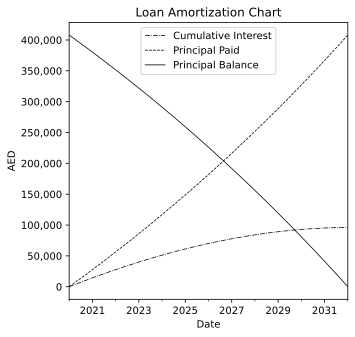

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
home_investment_schedule.plot(
    x="Date", y="Cumulative Interest", color="k", linestyle="-.", linewidth=0.75, ax=ax
)
home_investment_schedule.plot(
    x="Date", y="Principal Paid", color="k", linestyle="--", linewidth=0.75, ax=ax
)
home_investment_schedule.plot(
    x="Date", y="Principal Balance", color="k", linestyle="-", linewidth=0.75, ax=ax
)
ax.set(xlabel="Date", ylabel=f"{currency}", title="Loan Amortization Chart")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.legend();

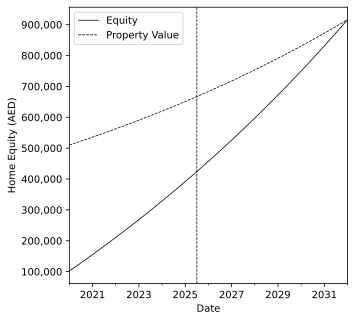

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
home_investment_schedule.plot(x="Date", y="Equity", color="k", linewidth=0.75, ax=ax)
home_investment_schedule.plot(
    x="Date", y="Property Value", color="k", linestyle="--", linewidth=0.75, ax=ax
)
ax.axvline(eval_end_date, color="k", linewidth=0.75, linestyle="--")
ax.set(xlabel="Date", ylabel=f"Home Equity ({currency})")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.legend();

In [6]:
i = np.searchsorted(dates, eval_end_date)
t = (eval_end_date - start_date).total_seconds() / (60**2 * 24 * 365)
print(f"Home Value - Start ({currency}) = {property_val:,.2f}")
print(f"Home Value - Mid 2025 ({currency}) = {prop_value[i]:,.2f}")
print(f"% Increase in Home Value = {prop_value[i] / property_val - 1:.2%}")
print(
    f"Property Value Appreciation (CAGR) = {(prop_value[i] / property_val) ** (1 / t) - 1:,.2%}"
)
print()

total_investment = principal_portion[: i + 1].sum() + down_payment
current_home_equity = prop_value[i] - principal_bal[i]
print(f"Total Investment ({currency}) = {total_investment:,.2f}")
print(f"Home Equity Value ({currency}) = {current_home_equity:,.2f}")
print(f"Total Rental Income ({currency}) = {rental_income[: i + 1].sum():,.2f}")
print(f"Interest Cost ({currency}) = {interest_portion[: i + 1].sum():,.2f}")

hpr = (
    current_home_equity
    - total_investment
    + rental_income[: i + 1].sum()
    - interest_portion[: i + 1].sum()
    - closing_costs
) / total_investment
print(f"Holding Period Return = {hpr:,.2%}")

Home Value - Start (AED) = 510,000.00
Home Value - Mid 2025 (AED) = 666,977.71
% Increase in Home Value = 30.78%
Property Value Appreciation (CAGR) = 5.00%

Total Investment (AED) = 267,169.26
Home Equity Value (AED) = 424,146.97
Total Rental Income (AED) = 172,568.86
Interest Cost (AED) = 65,830.74
Holding Period Return = 88.23%


Note: analysis excludes costs associated to selling/exiting of the real estate investment and the following costs incurred at the time of purchase and during the holding period: 
- Rent renewal costs
- Property maintenance costs (property management fee)
- Depreciation
- Broker commission (purchase and rent)
- Registration fee
- DLD transfer fee
- Mortgage fee
- Ejari fee (incl. renewals)
- Insurance fee

### S&P 500 Investment

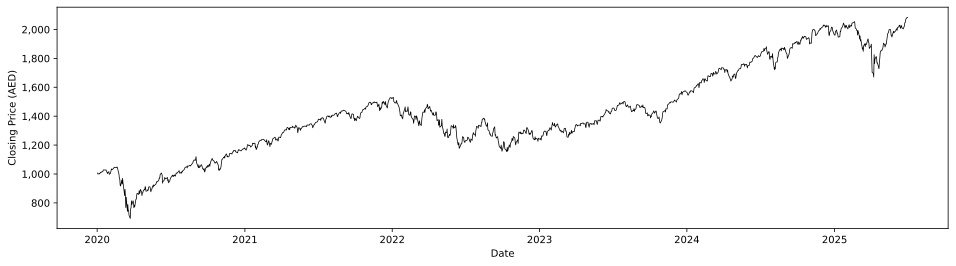

In [7]:
plt.figure(figsize=(16, 4))
plt.plot(snp500_hist["Date"], snp500_hist["Close"], color="k", linewidth=0.75)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.xlabel("Date")
plt.ylabel(f"Closing Price ({currency})");

In [8]:
# S&P 500 Value CAGR
t = (snp500_hist["Date"].iloc[-1] - snp500_hist["Date"].iloc[0]).total_seconds() / (
    60**2 * 24 * 365
)
cagr = (snp500_hist["Close"].iloc[-1] / snp500_hist["Close"].iloc[0]) ** (1 / t) - 1
print(f"S&P 500 CAGR = {cagr:.2%}")

S&P 500 CAGR = 14.14%


In [9]:
investment_dates = np.flatnonzero(
    np.diff(snp500_hist["Date"].dt.month, prepend=start_date.month)
)
monthly_investment = np.zeros(snp500_hist.shape[0])
monthly_investment[investment_dates] = emi  # principal_portion[1:i+1]
monthly_investment[0] = down_payment + closing_costs

trading_fees = monthly_investment * 0.0025
trading_fees = np.where(
    trading_fees < 1, np.where(trading_fees == 0, 0, 1), trading_fees
)

investment_df = pd.DataFrame()
investment_df["Date"] = snp500_hist["Date"]
investment_df["Investments"] = monthly_investment
investment_df["Delta Shares"] = investment_df["Investments"] / snp500_hist["Open"]
investment_df["Trading Fees"] = trading_fees
investment_df["Total Shares"] = investment_df["Delta Shares"].cumsum()
investment_df["Portfolio Value"] = investment_df["Total Shares"] * snp500_hist["Close"]
investment_df["Avg Price"] = (
    investment_df["Investments"].cumsum() / investment_df["Total Shares"]
)
investment_df["Dividend Income"] = (
    investment_df["Total Shares"] * snp500_hist["Dividends"]
) * (1 - 0.3)  # Withholding Tax 30%

investment_df

,Date,Investments,Delta Shares,Trading Fees,Total Shares,Portfolio Value,Avg Price,Dividend Income
0,2020-01-02 00:00:00-05:00,130000.0,129.621200,325.00,129.621200,130494.132431,1002.922364,0.000000
1,2020-01-03 00:00:00-05:00,0.0,0.000000,0.00,129.621200,129540.854585,1002.922364,0.000000
2,2020-01-06 00:00:00-05:00,0.0,0.000000,0.00,129.621200,130026.233050,1002.922364,0.000000
3,2020-01-07 00:00:00-05:00,0.0,0.000000,0.00,129.621200,129667.650526,1002.922364,0.000000
4,2020-01-08 00:00:00-05:00,0.0,0.000000,0.00,129.621200,130336.690024,1002.922364,0.000000
...,...,...,...,...,...,...,...,...
1376,2025-06-25 00:00:00-04:00,0.0,0.000000,0.00,297.093454,608402.805049,1203.325067,0.000000
1377,2025-06-26 00:00:00-04:00,0.0,0.000000,0.00,297.093454,613218.131793,1203.325067,0.000000
1378,2025-06-27 00:00:00-04:00,0.0,0.000000,0.00,297.093454,616261.667453,1203.325067,0.000000
1379,2025-06-30 00:00:00-04:00,0.0,0.000000,0.00,297.093454,619341.871415,1203.325067,1331.841728


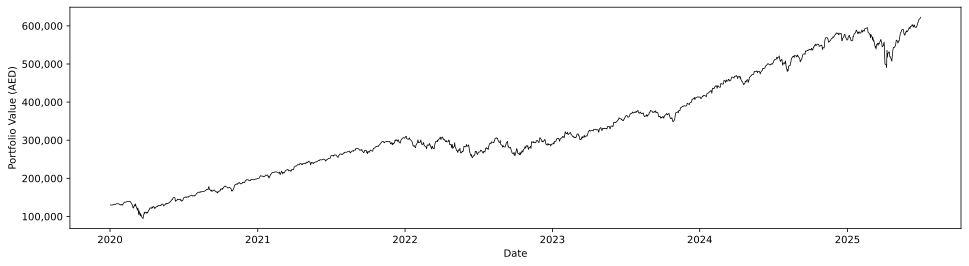

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(
    investment_df["Date"], investment_df["Portfolio Value"], color="k", linewidth=0.75
)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.xlabel("Date")
plt.ylabel(f"Portfolio Value ({currency})");

In [11]:
portfolio_value_end = investment_df["Portfolio Value"].to_numpy()[-1]
total_invested = investment_df["Investments"].sum()
total_dividends = investment_df["Dividend Income"].sum()
snp500_return = (
    portfolio_value_end + total_dividends - trading_fees.sum() - total_invested
) / total_invested

print(f"Total Investment ({currency}) = {total_invested:,.2f}")
print(f"Portfolio Value ({currency}) = {portfolio_value_end:,.2f}")
print(f"Dividend Income After Tax ({currency}) = {total_dividends:,.2f}")
print(f"Total Trading Cost = {investment_df['Trading Fees'].sum()}")

print(f"Holding Period Return = {snp500_return:.2%}")

Total Investment (AED) = 361,000.00
Portfolio Value (AED) = 622,565.85
Dividend Income After Tax (AED) = 19,716.38
Total Trading Cost = 902.5
Holding Period Return = 77.67%
